## Περιεχόμενα

- Filter Μέθοδοι Feature Selection, κατά τις οποίες πραγματοποιείται επιλογή των χαρακτηριστικών βάσει καθιερωμένων κριτηρίων, συγκεκριμένα:
    - Mutual information μεταξύ των χαρακτηριστικών και του χαρακτηριστικού στόχου (εξαγωγή 2 υποσυνόλων, ανάλογα με ένα threshold).
    - Cramer's V μεταξύ των χαρακτηριστικών και του χαρακτηριστικού στόχου (εξαγωγή 2 υποσυνόλων, ανάλογα με ένα threshold).
    - Mutual information, Cramer's V και Pearson Correlation μεταξύ των χαρακτηριστικών για τυχόν redundancy.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.model_selection import (train_test_split, 
                                     StratifiedKFold)

from scipy.stats import chi2_contingency

In [2]:
def cramers_v(x, y):
    '''
    Συνάρτηση που υπολογίζει το cramers v score μεταξύ 
    δύο χαρακτηριστικών
    
    Παίρνει δύο dataframe με διαστάσεις (n_data x 1)
    
    Επιστρέφει το cramers v score (float)
    '''
    
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    
    return np.sqrt(chi2 / (contingency_table.sum().sum() * (min(contingency_table.shape) - 1)))

In [3]:
def compute_mutual_info_matrix(df):
    '''
    Συνάρτηση που υπολογίζει το mutual information μεταξύ 
    όλων των συνδυασμών των χαρακτηριστικών. 
    
    Παίρνει dataframe με διαστάσεις (n_data x n_features)
    
    Επιστρέφει numpy array με διαστάσεις (n_features x n_features)
    με μηδέν στη διαγώνιο.
    '''
    
    n_features = df.shape[1]
    mutual_info_matrix = np.zeros((n_features, n_features))

    for i in range(n_features):
        for j in range(n_features):
            if i != j: # αν το χαρακτηριστικό i δεν είναι το ίδιο με το j
                
                # Mutual information των χαρακτηριστικών i και j
                # όταν το χαρακτηριστικό j είναι κατηγορικό -> mutual_info_classif
                if df.iloc[:, j].name not in ['Age', 'Height', 'Weight']:
                    mutual_info_matrix[i, j] = mutual_info_classif(
                        df.iloc[:, [i]], df.iloc[:, j], random_state=42)[0]
                    
                # Mutual information των χαρακτηριστικών i και j
                # όταν το χαρακτηριστικό j είναι συνεχές -> mutual_info_regression
                else:
                    mutual_info_matrix[i, j] = mutual_info_regression(
                        df.iloc[:, [i]], df.iloc[:, j], random_state=42)[0]
            
    return mutual_info_matrix

In [4]:
df = pd.read_csv("data_preprocessed.csv")

In [5]:
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,Gender_Female,family_history_with_overweight_yes,FAVC_no,SMOKE_no,SCC_no,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,-0.522124,-0.875589,-0.862558,2.0,3.0,1,2.0,0.0,1.0,0,1,1,1,1,1,1,0,1
1,-0.522124,-1.947599,-1.168077,3.0,3.0,1,3.0,3.0,0.0,1,1,1,1,0,0,1,0,1
2,-0.206889,1.054029,-0.366090,2.0,3.0,1,2.0,2.0,1.0,2,0,1,1,1,1,1,0,1
3,0.423582,1.054029,0.015808,3.0,3.0,1,2.0,2.0,0.0,2,0,0,1,1,1,0,1,2
4,-0.364507,0.839627,0.122740,2.0,1.0,1,2.0,0.0,0.0,1,0,0,1,1,1,1,0,3


## Mutual information

- Υπολογισμός του mutual information μεταξύ των χαρακτηριστικών με το χαρακτηριστικό στόχο

In [6]:
features = [col for col in df.columns if col != 'NObeyesdad']

mi = mutual_info_classif(
    df[features],
    df['NObeyesdad'],
)

mi_score = pd.DataFrame({
    "Feature": features,
    "Mutual Information": mi
})

mi_score = mi_score.sort_values(by='Mutual Information', ascending=False)
mi_score = mi_score.reset_index().drop("index", axis=1)

In [8]:
mi_score

,Feature,Mutual Information
0,Weight,1.257719
1,Age,0.585414
2,Height,0.419002
3,Gender_Female,0.205729
4,FCVC,0.165466
5,NCP,0.152583
6,family_history_with_overweight_yes,0.152522
7,CAEC,0.148801
8,MTRANS_Public_Transportation,0.075128
9,FAVC_no,0.069490


- Κατάταξη των χαρακτηριστικών βάση Mutual information

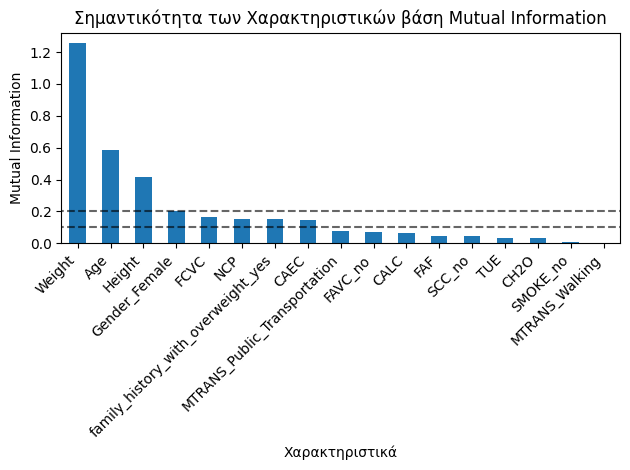

In [9]:
mi_score.sort_values(by='Mutual Information', ascending=False).plot.bar(x='Feature', y='Mutual Information', legend=False)
plt.title('Σημαντικότητα των Χαρακτηριστικών βάση Mutual Information')
plt.ylabel('Mutual Information')
plt.xlabel('Χαρακτηριστικά')
plt.xticks(rotation=45, ha='right')
plt.hlines(y=0.1, xmin=-1, xmax=18, color='black', linestyles = '--', alpha=0.6)
plt.hlines(y=0.2, xmin=-1, xmax=18, color='black', linestyles = '--', alpha=0.6)
plt.tight_layout()
plt.show()

- Με threshold mi > 0.2, παραμένουν τα χαρακτηριστικά: `Weight`, `Age`, `Height`, `Gender`
- Με threshold mi > 0.1, παραμένουν τα χαρακτηριστικά: `Weight`, `Age`, `Height`, `Gender`, `family_history_with_overweight`, `CAEC`, `FCVC` και `NCP`

- Υπολογισμός mutual information κάθε συνδυασμού χαρακτηριστικών 

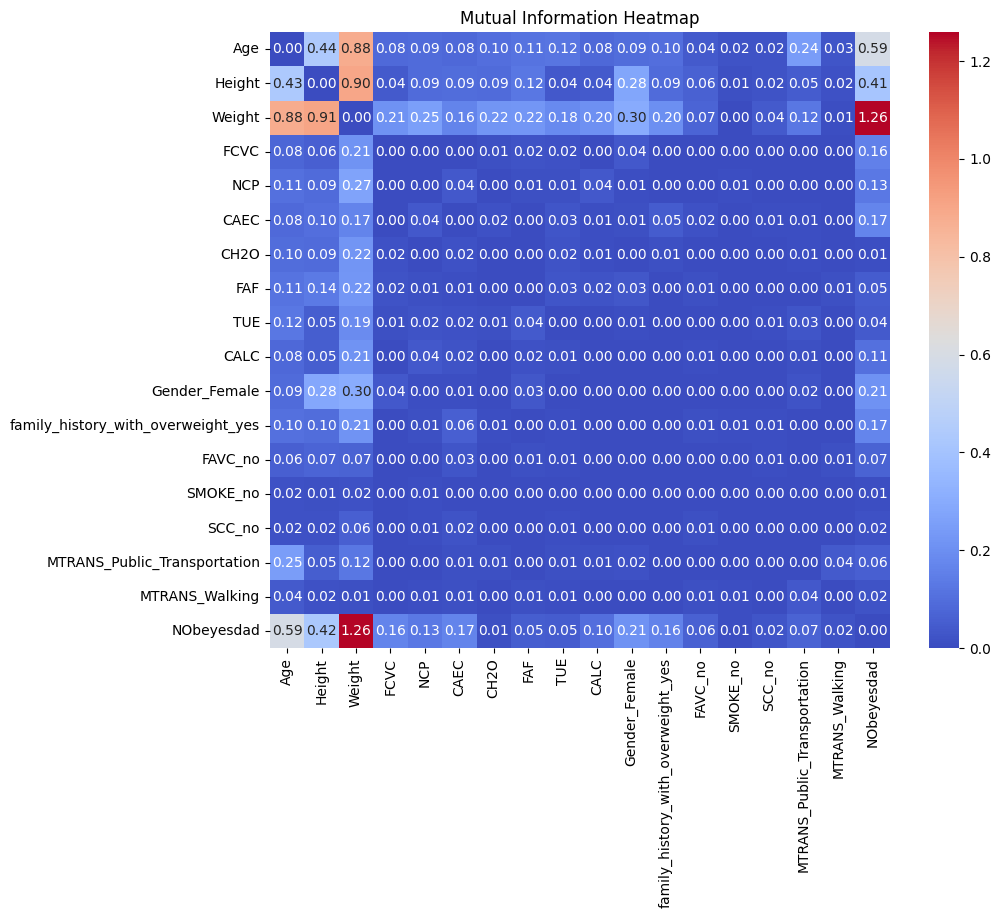

In [9]:
# υπολογισμός του mutual information matrix
mutual_info_matrix = compute_mutual_info_matrix(df)

# Δημιουργία heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=df.columns, yticklabels=df.columns)
plt.title("Mutual Information Heatmap")
plt.show()

- Παρατηρείται correlation μεταξύ των τριών αριθμητικών χαρακτηριστικών

## Pearson Correlation για το correlation μεταξυ των αριθμητικών χαρακτηριστικών.
- Τιμές κοντά στο 1 ή στο -1, πιθανά να υποδηλώνει redundancy του ζεύγους των χαρακτηριστικών (Pearson Correlation $ \in [-1, 1] $)

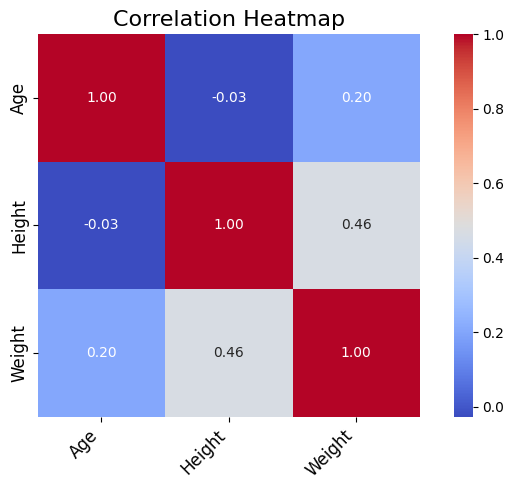

In [10]:
df_num = df[["Age", "Height", "Weight"]]
df_num_hm = df_num.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(df_num_hm, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- Αναφορικά με τις κατανομές των αριθμητικών χαρακτηριστικών στο ακόλουθο pairplot:
  - Η κάθε κατηγορία `NObeyesdad` έχει διαφορετική κατανομή βάρους, παρουσιάζοντας μια τάση αναλογίας (περισσότερο βάρος -> μεγαλύτερη κατηγορία παχυσαρκίας)
  - Το ύψος παρουσιάζει διαφορές στις κατανομές, χωρίς όμως οι όμοιες κατηγορίες να έχουν όμοιες κατανομές 
  - Οι κατανομές αναφορικά με την ηλικία φαίνεται να έχουν μία τάση με το βαθμό παχυσαρκίας (μεγαλύτερη ηλικία -> μεγαλύτερη κατηγορία παχυσαρκίας)
  
- Επιπλέον, στο ακόλουθο `pairplot` φαίνεται και η καλύτερη διαχωριστική ικανότητα κατά των συνδυασμό των χαρακτηριστικών `Height` και `Weight`, σε σύγκριση με την διαχωριστική ικανότητα των δύο μεμονωμένων χαρακτηριστικών. Συνεπώς η συσχέτιση των δύο χαρακτηριστικών (0.46 pearson correlation), δεν σημαίνει ότι τα δύο χαρακτηριστικά προσφέρουν την ίδια πληροφορία (reduntant).

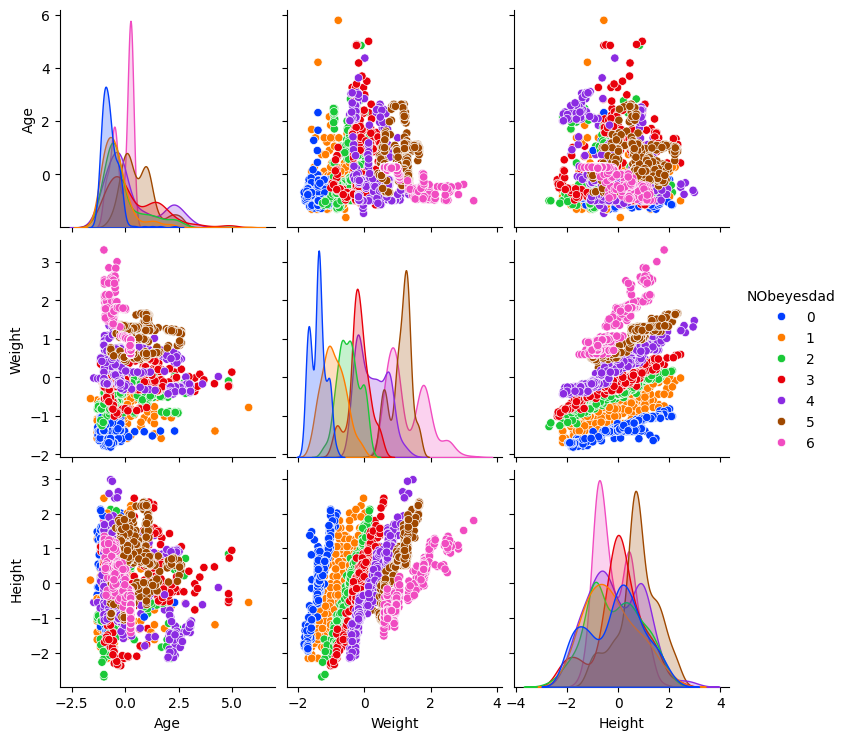

In [11]:
sns.pairplot(df, hue='NObeyesdad', vars = ["Age", "Weight", "Height"], diag_kind='kde', palette='bright')
plt.show()

## Cramer V score

- Υπολογισμός του Cramer V score μεταξύ των χαρακτηριστικών με το χαρακτηριστικό στόχο
- Για να πραγματοποιηθεί η σύγκριση και των συνεχών μεταβλητών, πραγματοποιείται αρχικά διακριτοποίηση (discretize) των μεταβλητών αυτών

In [12]:
trans = KBinsDiscretizer(encode='ordinal')

In [13]:
trans.fit(df[["Age", "Weight", "Height"]])

KBinsDiscretizer(encode='ordinal')

In [14]:
df[["Age", "Weight", "Height"]] = trans.transform(df[["Age", "Weight", "Height"]])

In [15]:
cramer_v_score = pd.Series()
for col in features:
    cramer_v_score[col] = cramers_v(df[col], df['NObeyesdad'])
    
cramer_v_score = pd.DataFrame(data = cramer_v_score)
cramer_v_score = cramer_v_score.reset_index()
cramer_v_score.columns = ['Feature', 'Cramer V']
cramer_v_score = cramer_v_score.sort_values(by = 'Cramer V', ascending=False).reset_index()
cramer_v_score = cramer_v_score.drop('index', axis=1)

In [16]:
cramer_v_score

,Feature,Cramer V
0,Weight,0.660222
1,Gender_Female,0.558194
2,family_history_with_overweight_yes,0.542805
3,FCVC,0.366442
4,CAEC,0.356079
5,Age,0.344346
6,FAVC_no,0.332469
7,CALC,0.281023
8,NCP,0.277588
9,MTRANS_Public_Transportation,0.266672


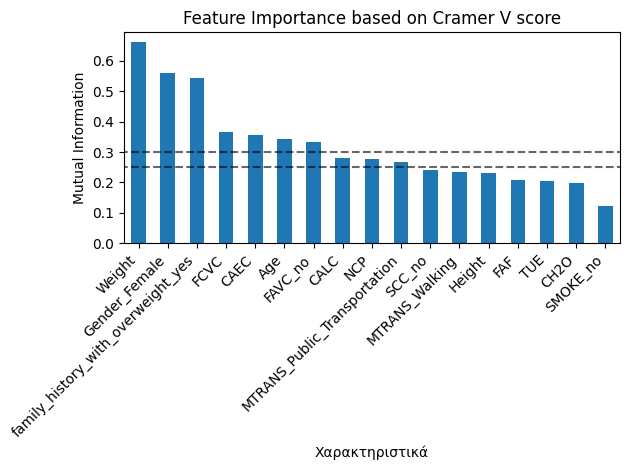

In [17]:
cramer_v_score.plot.bar(x='Feature', y='Cramer V', legend=False)
plt.title('Feature Importance based on Cramer V score')
plt.ylabel('Mutual Information')
plt.xlabel('Χαρακτηριστικά')
plt.xticks(rotation=45, ha='right')
plt.hlines(y=0.3, xmin=-1, xmax=18, color='black', linestyles = '--', alpha=0.6)
plt.hlines(y=0.25, xmin=-1, xmax=18, color='black', linestyles = '--', alpha=0.6)

plt.tight_layout()
plt.show()

In [18]:
# ίδια λογική με τη συνάρτηση compute_mutual_info_matrix
# αντί για array οι τιμές καταχωρούνται σε df

n_features = df.shape[1]

temp_df = np.zeros((n_features, n_features))

cramers_v_results = pd.DataFrame(data = temp_df, columns=df.columns, index=df.columns)

for feature1 in df.columns:
    for feature2 in df.columns:
        if feature1 != feature2:
            cramers_v_val = cramers_v(df[feature1], df[feature2])
            cramers_v_results.loc[feature1, feature2] = cramers_v_val

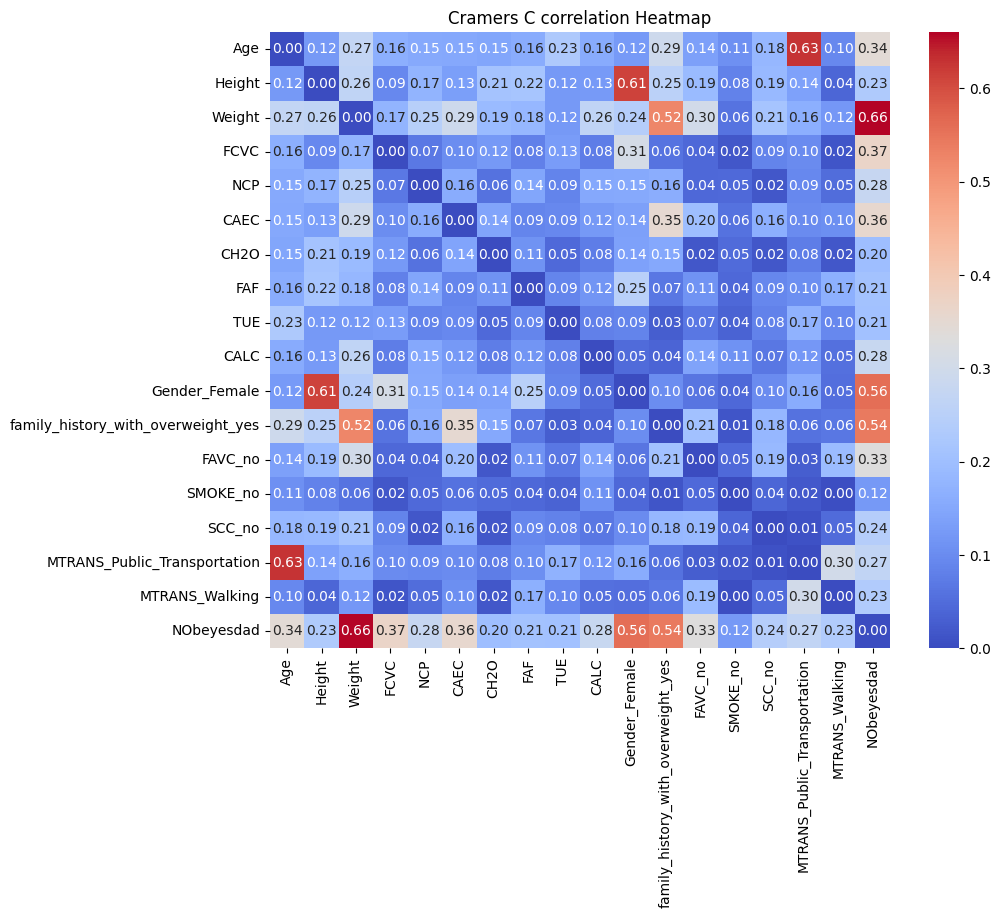

In [19]:
cr_v = np.array(cramers_v_results).astype('float')

plt.figure(figsize=(10, 8))
sns.heatmap(cr_v, annot=True, cmap='coolwarm', xticklabels=df.columns, yticklabels=df.columns, cbar=True, fmt=".2f")
plt.title("Cramers C correlation Heatmap")
plt.show()

- Με theshold 0.30, τα χαρακτηριστικά είναι τα εξής: `Weight`, `Gender_Female`, `family_history_with_overweight_yes`, `FCVC`, `CAEC`, `Age`, `FAVC_no`
- Με threshold 0.25, προστίθενται και τα `CALC`, `NCP`, `MTRANS_Public_Transportation`
- Επίσης, παρατηρείται correlation ανάμεσα στα χαρακτηριστικά `Age` - `MTRANS_Public_Transportation`, `Height` - `Gender` και `Weight` - `family_history_with_overweight`